In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn

import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

In [3]:
data = pd.read_csv('FinalData2.csv').drop(['Unnamed: 0'], axis=1).drop_duplicates()
# Drop the categorical variables and rows with Pop_Est=0
rows = [i for i in data.index if data.Pop_Est[i]!=0]

df = data.loc[rows].drop(['State', 'Area', 'Region', 'StateCode'], axis=1)
df.head()

,Year,UnemploymentRate,Change,LHS,HS,SC,BD,Pop_Est,MedianIncome,RegionCode,AreaCode,Min_Wage,CPI
0,2007,4.0,0.0,15.2,31.0,29.8,24.0,4737752,42212.0,2,9,5.15,207.342417
1,2008,5.7,1.7,15.2,31.0,29.8,24.0,4752904,44476.0,2,9,5.85,215.302500
2,2009,11.0,5.3,15.2,31.0,29.8,24.0,4768103,39980.0,2,9,6.55,214.537000
3,2010,10.5,-0.5,15.2,31.0,29.8,24.0,4783352,40933.0,2,9,7.25,218.055500
4,2011,9.6,-0.9,15.2,31.0,29.8,24.0,4798649,42590.0,2,9,7.25,224.939167


### Since some of the population estimates are for the entire state and some are for individual counties, I will take the log of these values.

In [4]:
# Take the log of the population estimate
df['Log_pop'] = np.log(df.Pop_Est)

In [5]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

### The education variables are correlated with each other, so I will use PCA to reduce the dimensions. We can look at the explained variance of each PCA features to determine how many features to keep.

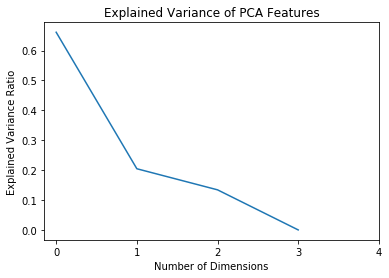

In [6]:
# Use PCA for dimension reduction
X1 = df[['LHS', 'HS', 'SC', 'BD']]

pca = PCA()
pca.fit(X1)

plt.plot(pca.explained_variance_ratio_)
plt.xticks(range(0,5))
plt.xlabel('Number of Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance of PCA Features')
plt.rcParams['figure.figsize']=[8,8]
plt.savefig('PCA Features plot')
plt.show()

In [7]:
print(np.round(pca.explained_variance_ratio_, decimals=4)*100)

[66.13 20.46 13.41  0.  ]


### From the plot above, we can see that all the variance is explained by the first three features, so I will not use the fourth feature in the model.

### I will add the first three PCA features to the dataframe, and then scale all the variables using the MinMaxScaler.

In [8]:
transformed = pca.fit_transform(X1)
# Add the transformed features to the dataframe
df['PCA1'] = transformed[:,0]
df['PCA2'] = transformed[:,1]
df['PCA3'] = transformed[:,2]
 
# Scale all the values
scaler = MinMaxScaler()
df2 = pd.DataFrame(scaler.fit_transform(df))

df2.columns = df.columns
df2.head()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Year,UnemploymentRate,Change,LHS,HS,SC,BD,Pop_Est,MedianIncome,RegionCode,AreaCode,Min_Wage,CPI,Log_pop,PCA1,PCA2,PCA3
0,0.0,0.104317,0.413793,0.276892,0.509356,0.512465,0.272021,0.119830,0.147690,0.75,0.004717,0.282486,0.000000,0.837276,0.343985,0.364978,0.444858
1,0.1,0.165468,0.487069,0.276892,0.509356,0.512465,0.272021,0.120213,0.194559,0.75,0.004717,0.361582,0.210711,0.837520,0.343985,0.364978,0.444858
2,0.2,0.356115,0.642241,0.276892,0.509356,0.512465,0.272021,0.120598,0.101482,0.75,0.004717,0.440678,0.190448,0.837765,0.343985,0.364978,0.444858
3,0.3,0.338129,0.392241,0.276892,0.509356,0.512465,0.272021,0.120983,0.121211,0.75,0.004717,0.519774,0.283586,0.838010,0.343985,0.364978,0.444858
4,0.4,0.305755,0.375000,0.276892,0.509356,0.512465,0.272021,0.121370,0.155515,0.75,0.004717,0.519774,0.465804,0.838255,0.343985,0.364978,0.444858


### Next I will fit a  linear model to the data, and calculate the mean absolute error. This will be used as a baseline to compare the results of other models. 

In [9]:
# Drop the target values, and features that are not needed
X = df2.drop(['UnemploymentRate', 'LHS', 'HS', 'SC', 'BD', 'Pop_Est', 'RegionCode'], axis=1)
y = df2.UnemploymentRate
features = X.columns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Instantiate the linear model, and fit it to the training data
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Test the model on the test set
y_pred = model.predict(X_test)

print('The accuracy for the training data is: {}'.format(model.score(X_train, y_train)))
print('The accuracy for the test data is: {}'.format(model.score(X_test, y_test)))

print('The mean absolute error is: {}'.format(mean_absolute_error(y_pred, y_test, multioutput = 'uniform_average')))


The accuracy for the training data is: 0.3026638188518773
The accuracy for the test data is: 0.30768443524802536
The mean absolute error is: 0.06891652559001245


In [10]:
# Use stats models to fit a linear model and print the summary
from statsmodels.formula.api import ols

lin_model = ols('UnemploymentRate ~ Year+Change+MedianIncome+RegionCode+AreaCode+Log_pop+PCA1+PCA2', data=df).fit()
print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:       UnemploymentRate   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1458.
Date:                Sat, 09 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:20:55   Log-Likelihood:                -82537.
No. Observations:               34898   AIC:                         1.651e+05
Df Residuals:                   34889   BIC:                         1.652e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       68.1393     10.901      6.251   

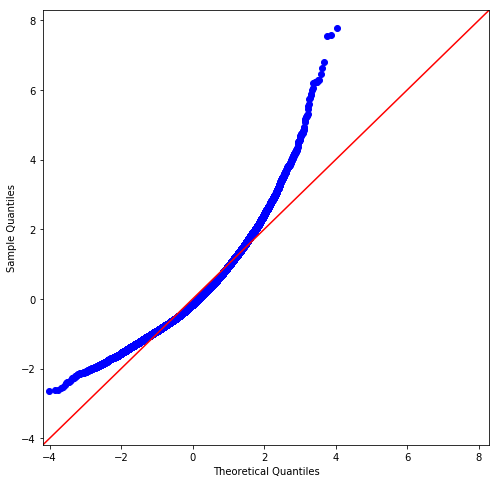

In [11]:
sm.qqplot(lin_model.resid, fit=True, line='45')
plt.rcParams['figure.figsize']=[8,8]
plt.show()

### With the linear model, the mean absolute error is about 0.07. Now I will try several other algorithms to try to improve the model. The first one I will use is XGBoost, a tree based model that is know to be fast and very accurate.

## XGBoost

In [12]:
import xgboost as xgb

# Split the data into training and test sets, using 30 percent of the data for the test set. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [13]:
# Instantiate the model and fit it to the training data
xg_reg=xgb.XGBRegressor(Objective='reg:linear',seed=20,colsample_bytree=0.8,learning_rate=0.3,max_depth=6,
                        n_estimators=500)

xg_reg.fit(X_train, y_train)
pred = xg_reg.predict(X_test)

print('The mean absolute error is: {}'.format(mean_absolute_error(pred, y_test)))

The mean absolute error is: 0.024801755027798748


### This model is significantly better than the linear model, with a mean absolute error of 0.029. Next I will use a randomized search to tune the hyperparameters, and hopefully get an even better model. 

In [14]:
%%time
# Use a randomized search to select the best values for the hyperparameters

params = {'n_estimators': stats.randint(400,1000), 
         'learning_rate': stats.uniform(0.01, 0.2), 
         'max_depth': [4, 5, 6, 7, 8, 9, 10],
         'colsample_bytree': stats.uniform(0.5, 0.45), 
         'min_child_weight': [1, 2, 3, 4]
         }

n_iter_search=20

reg = xgb.XGBRegressor(Objective='reg:linear')

randomSearchModel = RandomizedSearchCV(reg, param_distributions=params, n_iter=n_iter_search, 
                                       scoring='neg_mean_absolute_error', refit=True, random_state=20, cv=5)
# Fit the model to the training data
randomSearchModel.fit(X_train, y_train)

optimal_params = randomSearchModel.best_params_
print(optimal_params)

{'colsample_bytree': 0.7646588604847734, 'learning_rate': 0.1895427455818836, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 793}
CPU times: user 34min 26s, sys: 14.4 s, total: 34min 40s
Wall time: 36min


In [15]:
pred = randomSearchModel.predict(X_test)
print(mean_absolute_error(pred, y_test))

0.02305079564677123


### By tuning the hyperparameters, I was able to improve the model even more. We get a mean absolute error of 0.023. 

In [16]:
xgb_model = xgb.XGBRegressor(Objective='reg:linear', seed=20, 
                             colsample_bytree = optimal_params['colsample_bytree'],
                            learning_rate = optimal_params['learning_rate'],
                            max_depth = optimal_params['max_depth'],
                            min_child_weight = optimal_params['min_child_weight'],
                            n_estimators = optimal_params['n_estimators'])

xgb_model.fit(X_train, y_train)

XGBRegressor(Objective='reg:linear', base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.7646588604847734, gamma=0,
       learning_rate=0.1895427455818836, max_delta_step=0, max_depth=8,
       min_child_weight=3, missing=None, n_estimators=793, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=20, silent=True, subsample=1)

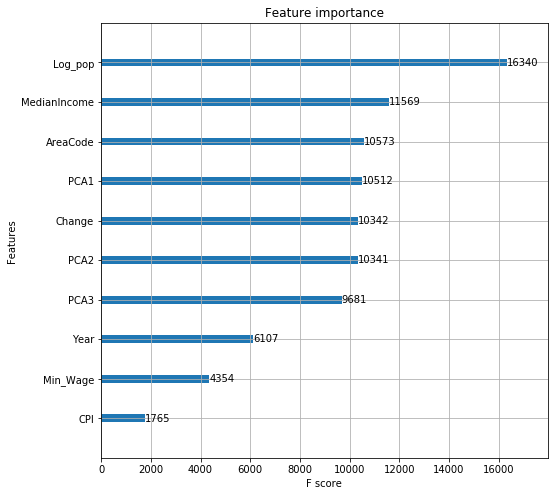

In [17]:
# Plot the importance of the features used in the model
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize']=[8, 8]
plt.savefig('FeatureImportancePlot.png')
plt.show()

### Next I will use CatBoost, another machine learning algorithm, to try to construct a better model. 

In [18]:
from catboost import CatBoostRegressor
cb_model = CatBoostRegressor(iterations=100, learning_rate=0.35, depth=8, loss_function='MAE')

In [19]:
data_scaled = pd.DataFrame(scaler.fit_transform(df))
data_scaled.columns = df.columns
data_scaled.head()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Year,UnemploymentRate,Change,LHS,HS,SC,BD,Pop_Est,MedianIncome,RegionCode,AreaCode,Min_Wage,CPI,Log_pop,PCA1,PCA2,PCA3
0,0.0,0.104317,0.413793,0.276892,0.509356,0.512465,0.272021,0.119830,0.147690,0.75,0.004717,0.282486,0.000000,0.837276,0.343985,0.364978,0.444858
1,0.1,0.165468,0.487069,0.276892,0.509356,0.512465,0.272021,0.120213,0.194559,0.75,0.004717,0.361582,0.210711,0.837520,0.343985,0.364978,0.444858
2,0.2,0.356115,0.642241,0.276892,0.509356,0.512465,0.272021,0.120598,0.101482,0.75,0.004717,0.440678,0.190448,0.837765,0.343985,0.364978,0.444858
3,0.3,0.338129,0.392241,0.276892,0.509356,0.512465,0.272021,0.120983,0.121211,0.75,0.004717,0.519774,0.283586,0.838010,0.343985,0.364978,0.444858
4,0.4,0.305755,0.375000,0.276892,0.509356,0.512465,0.272021,0.121370,0.155515,0.75,0.004717,0.519774,0.465804,0.838255,0.343985,0.364978,0.444858


In [34]:
X3 = data_scaled.drop(['UnemploymentRate', 'LHS', 'HS', 'SC', 'BD', 'RegionCode', 'Pop_Est'], axis=1)
y3 = data_scaled.UnemploymentRate

In [21]:
# Split the data into training and test sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=10)

# Fit the model to the training data
cb_model.fit(X_train3, y_train3, eval_set=(X_test3, y_test3), verbose=False)

In [22]:
y_pred3 = cb_model.predict(X_test3)
print(mean_absolute_error(y_pred3, y_test3))

0.06800204062153359


### With this model, we get a mean absolute error of 0.068. Now I will tune the hyperparameters, and hopefully improve the model. 

In [26]:
%%time
params = {
    'iterations': [150, 200, 300],
    'depth': [8,9,10],
    'learning_rate':[0.05, 0.1, 0.2]
    
}

n_iter_search=20

cb_reg = CatBoostRegressor(loss_function='MAE')

# Use a randomized search to find the optimal hyperparameters
search_model = RandomizedSearchCV(cb_reg, param_distributions=params, n_iter=n_iter_search,
                                 scoring='neg_mean_absolute_error', refit=True, random_state=20, cv=5)

# Fit the model to the training data
search_model.fit(X_train3, y_train3, verbose=False)


cb_optimal_params = search_model.best_params_
print(cb_optimal_params)

{'learning_rate': 0.05, 'iterations': 300, 'depth': 10}
CPU times: user 1h 38min 15s, sys: 1h 9min 12s, total: 2h 47min 28s
Wall time: 2h 18min 6s


In [30]:
cb_model = CatBoostRegressor(loss_function='MAE', learning_rate=0.05, iterations=300, depth=10)
cb_model.fit(X_train3, y_train3, verbose=False)

In [31]:
cb_model_pred = cb_model.predict(X_test3)
print(mean_absolute_error(cb_model_pred, y_test3))

0.03331997749782088


### After tuning the hyperparameters, I get a mean absolute error of 0.033. This is slightly higher than what I got with XGBoost, but still much better than the linear model. It appears that XGBoost results in the best model for this data.

### The table below summarizes the results from each model.

|Model Type | Number of Features| MAE  |
|-----------|-------------------|------|
| Sklearn Linear    |    10             |0.069 |
|-----------|-------------------|------|
| XGBoost   |    10             |0.023 |
|-----------|-------------------|------|
| CatBoost  |    10             | 0.033|